# Playing with CSKG grounding

# Setup for grounding

```
conda create -n mowgli python=3.6 
conda activate mowgli

git clone https://github.com/ucinlp/mowgli-uci

mv mowgli-uci grounding

cd grounding

pip install -r requirements.txt
conda install --yes faiss-cpu -c pytorch -n mowgli
python -m spacy download en_core_web_lg

cd ..
```

In [1]:
# IMPORTS
import pygraphviz as pgv
from IPython.display import Image

## I. Parsing questions and answers

In [2]:
import sys
sys.path.append('..')
from groundcn.graphify import graphify

In [3]:
def draw(G):
    return Image(G.draw(format='png', prog='dot'))

In [4]:
sentences=[
    'Max looked for the onions so that he could make a stew.',
#    'To get the bathroom counters dry after washing your face, take a small hand lotion and wipe away the extra water around the sink.',
#    'To get the bathroom counters dry after washing your face, take a small hand towel and wipe away the extra water around the sink.'
]

In [5]:
parse_trees=graphify.graphify_dataset(sentences)

/Users/filipilievski/opt/anaconda3/envs/mowgli/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/filipilievski/opt/anaconda3/envs/mowgli/lib/python3.7/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:56: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


In [6]:
parse_trees

[{'sentence': 'Max looked for the onions so that he could make a stew.',
  'tokenized_sentence': ['Max',
   'looked',
   'for',
   'the',
   'onions',
   'so',
   'that',
   'he',
   'could',
   'make',
   'a',
   'stew',
   '.'],
  'nodes': {'b8b44c42212269fa82b8a800e4d05b3b': {'phrase': ['looked'],
    'start_idx': 1,
    'end_idx': 1,
    'entity_type': [None]},
   'd7f12a857dcf22242159a4ac9c75e4a7': {'phrase': ['Max'],
    'start_idx': 0,
    'end_idx': 0,
    'entity_type': ['PERSON']},
   '9d49eb0165f37563ceec0f4aace44eeb': {'phrase': ['for', 'the', 'onions'],
    'start_idx': 2,
    'end_idx': 4,
    'entity_type': [None, None, None]},
   '38e60e63114e00d392d337e9a9c16898': {'phrase': ['so',
     'that',
     'he',
     'could',
     'make',
     'a',
     'stew'],
    'start_idx': 5,
    'end_idx': 11,
    'entity_type': [None, None, None, None, None, None, None]},
   '5ae027510ceb98789ca570c5ba998f3c': {'phrase': ['make'],
    'start_idx': 9,
    'end_idx': 9,
    'entity_type

### Nicer visualization

In [7]:
rels=[]
for sent_data in parse_trees:
    #print('Sentence:', sent_data['sentence'])
    #print('Tokenized sentence', sent_data['tokenized_sentence'])

    G=pgv.AGraph(strict=False, directed=True)
    
    nodes={}
    for n_id, n_data in sent_data['nodes'].items():
        nodes[n_id]=' '.join(n_data['phrase'])
    
    for e_id, e_data in sent_data['edges'].items():
        n1=nodes[e_data['head_node_id']]
        n2=nodes[e_data['tail_node_id']]
        rel=e_data['edge_name']
        edge=(e_data['head_node_id'], rel, e_data['tail_node_id'])
        rels.append(edge)
        
        G.add_edge(n1, n2, label=rel)
        

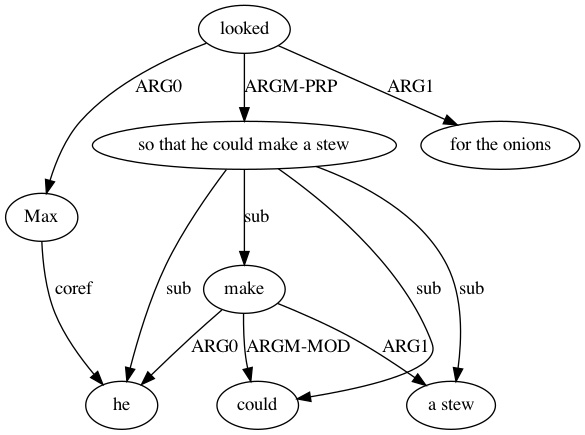

In [8]:
draw(G)

## II. Grounding questions and questions to ConceptNet

In [9]:
from groundcn.graphify import link

In [11]:
numberbatch_file='../groundcn/numberbatch-en-19.08.txt'

In [12]:
linked_data=link.link(parse_trees, embedding_file=numberbatch_file)

100%|██████████| 516782/516782 [00:36<00:00, 14254.83it/s]


In [13]:
rels

[('b8b44c42212269fa82b8a800e4d05b3b',
  'ARG0',
  'd7f12a857dcf22242159a4ac9c75e4a7'),
 ('b8b44c42212269fa82b8a800e4d05b3b',
  'ARG1',
  '9d49eb0165f37563ceec0f4aace44eeb'),
 ('b8b44c42212269fa82b8a800e4d05b3b',
  'ARGM-PRP',
  '38e60e63114e00d392d337e9a9c16898'),
 ('5ae027510ceb98789ca570c5ba998f3c',
  'ARG0',
  'd912aad50048df6360128cc250b052ad'),
 ('5ae027510ceb98789ca570c5ba998f3c',
  'ARGM-MOD',
  'b0885c0a23322aee012ea110470da1de'),
 ('5ae027510ceb98789ca570c5ba998f3c',
  'ARG1',
  '79b9dd007e266a328840fc9ae080deb7'),
 ('38e60e63114e00d392d337e9a9c16898',
  'sub',
  '5ae027510ceb98789ca570c5ba998f3c'),
 ('38e60e63114e00d392d337e9a9c16898',
  'sub',
  'd912aad50048df6360128cc250b052ad'),
 ('38e60e63114e00d392d337e9a9c16898',
  'sub',
  'b0885c0a23322aee012ea110470da1de'),
 ('38e60e63114e00d392d337e9a9c16898',
  'sub',
  '79b9dd007e266a328840fc9ae080deb7'),
 ('d7f12a857dcf22242159a4ac9c75e4a7',
  'coref',
  'd912aad50048df6360128cc250b052ad')]

In [14]:
links={}
for sent_data in linked_data:
    print('Sentence:', sent_data['sentence'])
    linkedG=pgv.AGraph(strict=False, directed=True)
    for n_id, n_data in sent_data['nodes'].items():
        print('Node phrase:', n_data['phrase'])
        for c in reversed(n_data['candidates']):
            print(c)
        print()
        
        links[n_id]=list(reversed(n_data['candidates']))[0]['uri']

    for edge in rels:
        linkedG.add_edge(links[edge[0]], links[edge[2]], label=edge[1])
    print()

Sentence: Max looked for the onions so that he could make a stew.
Node phrase: ['looked']
{'uri': '/c/en/give_glad_eye', 'score': 0.2498762607574463}
{'uri': '/c/en/uplook', 'score': 0.2498762607574463}
{'uri': '/c/en/look', 'score': 0.24307048320770264}
{'uri': '/c/en/lookt', 'score': 0.1385062336921692}
{'uri': '/c/en/looked', 'score': -1.0967254638671875e-05}

Node phrase: ['Max']
{'uri': '/c/en/maxy', 'score': 0.2219405174255371}
{'uri': '/c/en/maxie', 'score': 0.2098349928855896}
{'uri': '/c/en/maxine', 'score': 0.19799458980560303}
{'uri': '/c/en/maximus', 'score': 0.1656038761138916}
{'uri': '/c/en/max', 'score': 2.1219253540039062e-05}

Node phrase: ['for', 'the', 'onions']
{'uri': '/c/en/vidalia_onion', 'score': 0.11641442775726318}
{'uri': '/c/en/onion', 'score': 0.10344946384429932}
{'uri': '/c/en/ingredient_in_salsa', 'score': 0.09622251987457275}
{'uri': '/c/en/onions', 'score': 8.165836334228516e-05}
{'uri': '/c/en/for', 'score': 2.2649765014648438e-06}

Node phrase: ['so

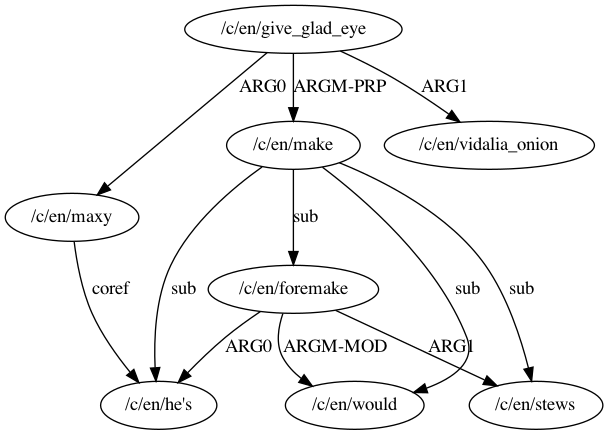

In [15]:
draw(linkedG)

## III. Grounding to CSKG

In [16]:
from groundcskg.graphify import link

In [21]:
ft_emb_file='../groundcskg/ft.txt'
graph_emb_file='../output/embeddings/graph_embedding.tsv'
bert_file='../output/embeddings/bert_nli_large_w2v_format.txt'

In [41]:
import importlib
importlib.reload(link)

<module 'groundcskg.graphify.link' from '../groundcskg/graphify/link.py'>

In [42]:
linked_data=link.link(parse_trees, embedding_file=bert_file)

['looked']
['Max']
['for', 'the', 'onions']
['so', 'that', 'he', 'could', 'make', 'a', 'stew']
['make']
['he']
['could']
['a', 'stew']


In [43]:
links={}
for sent_data in linked_data:
    print('Sentence:', sent_data['sentence'])
    linkedG=pgv.AGraph(strict=False, directed=True)
    for n_id, n_data in sent_data['nodes'].items():
        print('Node phrase:', n_data['phrase'])
        for c in reversed(n_data['candidates']):
            print(c)
        print()
        
        links[n_id]=list(reversed(n_data['candidates']))[0]['uri']

    for edge in rels:
        linkedG.add_edge(links[edge[0]], links[edge[2]], label=edge[1])
    print()

Sentence: Max looked for the onions so that he could make a stew.
Node phrase: ['looked']
{'uri': '/c/en/looks/n', 'score': 0.04993098974227905}
{'uri': '/c/en/looks/v', 'score': 0.04993098974227905}
{'uri': 'at:looked_at', 'score': 0.04919767379760742}
{'uri': '/c/en/looked/v', 'score': 0.023923277854919434}
{'uri': '/c/en/looked', 'score': 0.023923277854919434}

Node phrase: ['Max']
{'uri': '/c/en/reached_max', 'score': 0.06083834171295166}
{'uri': '/c/en/max/n/wn/artifact', 'score': 0.031417250633239746}
{'uri': '/c/en/max/a', 'score': 0.031417250633239746}
{'uri': '/c/en/max/v', 'score': 0.031417250633239746}
{'uri': '/c/en/max/n', 'score': 0.031417250633239746}

Node phrase: ['for', 'the', 'onions']
{'uri': '/c/en/cut_onions', 'score': 0.08701491355895996}
{'uri': '/c/en/multiplier_onions/n', 'score': 0.08609789609909058}
{'uri': '/c/en/storing_onions', 'score': 0.0823129415512085}
{'uri': "/c/en/know_one's_onions", 'score': 0.07984781265258789}
{'uri': "/c/en/know_one's_onions/v"

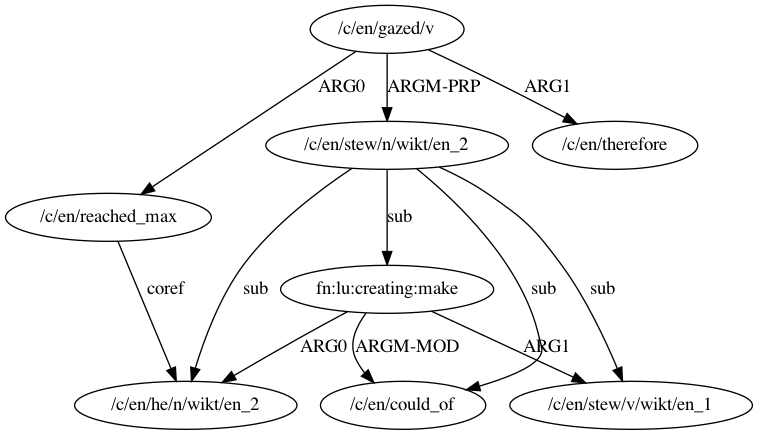

In [31]:
draw(linkedG)